<a href="https://colab.research.google.com/github/SJinLee/XAI2023/blob/main/x2.explainable3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* google drive에 연결
from google

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
!rm -r train valid
!unzip drive/MyDrive/xai/car_or_truck.zip > /dev/null

rm: cannot remove 'train': No such file or directory
rm: cannot remove 'valid': No such file or directory


In [6]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [7]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [8]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

In [9]:
ds_train_ = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [10]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [11]:
!rm -rf cv-course-models
!unzip drive/MyDrive/xai/base_models.zip > /dev/null

In [12]:
pretrained_base = tf.keras.models.load_model(
    'cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [14]:
checkpoint_filepath = 'save/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
    callbacks=[model_checkpoint_callback],
)

model.load_weights(checkpoint_filepath)

Epoch 1/30
79/80 [============================>.] - ETA: 0s - loss: 0.5692 - accuracy: 0.7136
Epoch 1: val_loss improved from inf to 0.52156, saving model to save/checkpoint
80/80 [==============================] - 13s 41ms/step - loss: 0.5693 - accuracy: 0.7133 - val_loss: 0.5216 - val_accuracy: 0.8252
Epoch 2/30
79/80 [============================>.] - ETA: 0s - loss: 0.4875 - accuracy: 0.8188
Epoch 2: val_loss improved from 0.52156 to 0.48313, saving model to save/checkpoint
80/80 [==============================] - 3s 35ms/step - loss: 0.4879 - accuracy: 0.8192 - val_loss: 0.4831 - val_accuracy: 0.8458
Epoch 3/30
79/80 [============================>.] - ETA: 0s - loss: 0.4456 - accuracy: 0.8479
Epoch 3: val_loss improved from 0.48313 to 0.46377, saving model to save/checkpoint
80/80 [==============================] - 3s 34ms/step - loss: 0.4460 - accuracy: 0.8480 - val_loss: 0.4638 - val_accuracy: 0.8545
Epoch 4/30
79/80 [============================>.] - ETA: 0s - loss: 0.4146 - ac

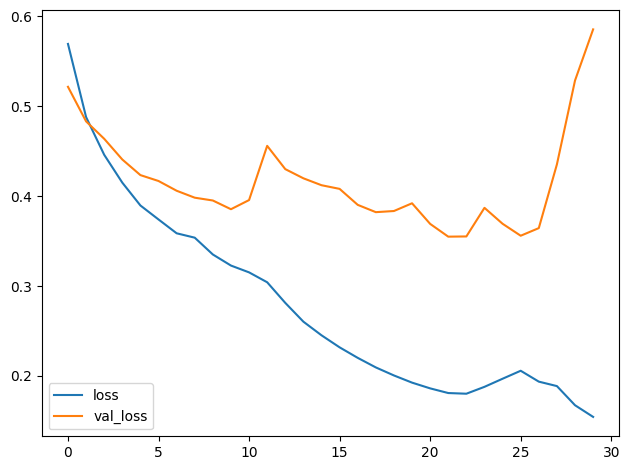

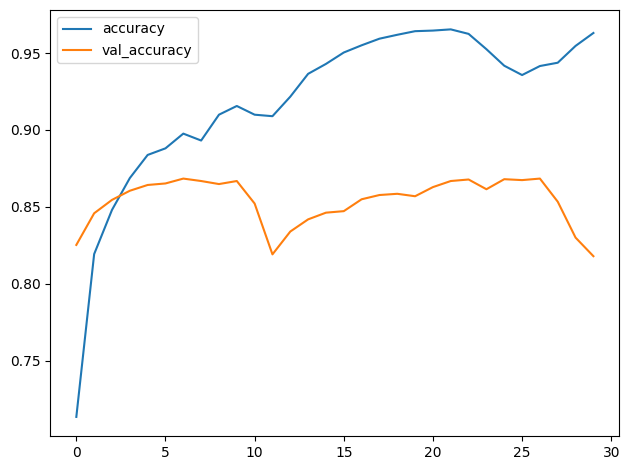

In [16]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [17]:
pred = model.predict(ds_valid)

79/79 [==============================] - 1s 15ms/step


In [18]:
pred

array([[4.7449800e-04],
       [2.4831034e-03],
       [1.2356007e-01],
       ...,
       [7.9621029e-01],
       [7.9621029e-01],
       [7.9621029e-01]], dtype=float32)

In [19]:
label = np.concatenate([x[1].numpy() for x in ds_valid])
label

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [20]:
(pred>0.5)*1==label

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [21]:
((pred>0.5)*1==label).mean()

0.866759057612354

In [57]:
imgs = [x[0].numpy() for x in ds_valid]
img = imgs[0][0]

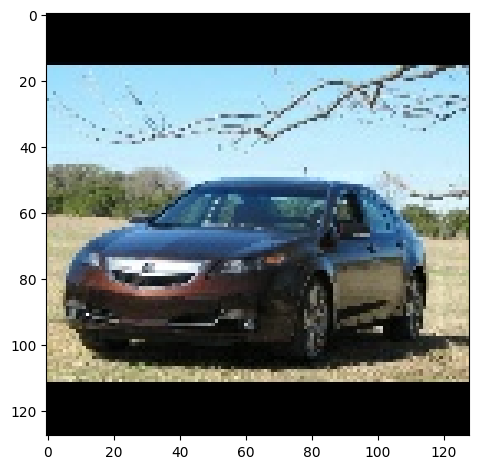

In [58]:
plt.imshow(img)

In [59]:
img.min(),img.max()

(0.0, 1.0)

In [60]:
model.predict(img[np.newaxis,:,:,:])

1/1 [==============================] - 0s 32ms/step


array([[0.00047497]], dtype=float32)

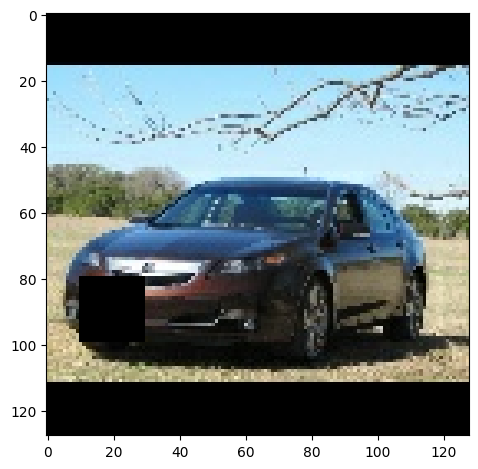

In [61]:
img_damaged = img.copy()
img_damaged[80:100,10:30,:] = 0
plt.imshow(img_damaged)

In [62]:
model.predict(img_damaged[np.newaxis,:,:,:])

1/1 [==============================] - 0s 29ms/step


array([[0.00091306]], dtype=float32)

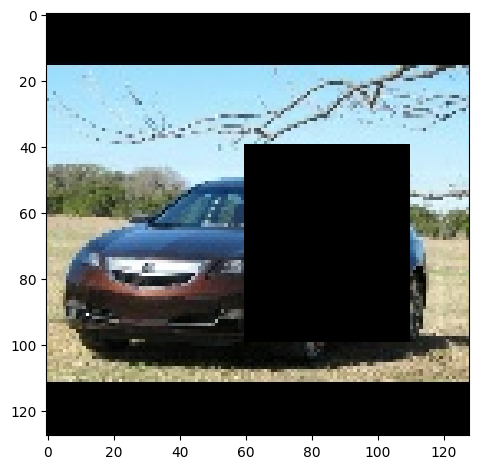

In [63]:
img_damaged = img.copy()
img_damaged[40:100,60:110,:] = 0
plt.imshow(img_damaged)

In [64]:
model.predict(img_damaged[np.newaxis,:,:,:])

1/1 [==============================] - 0s 29ms/step


array([[0.06088444]], dtype=float32)

In [65]:
img.shape

(128, 128, 3)

1/1 [==============================] - 0s 28ms/step


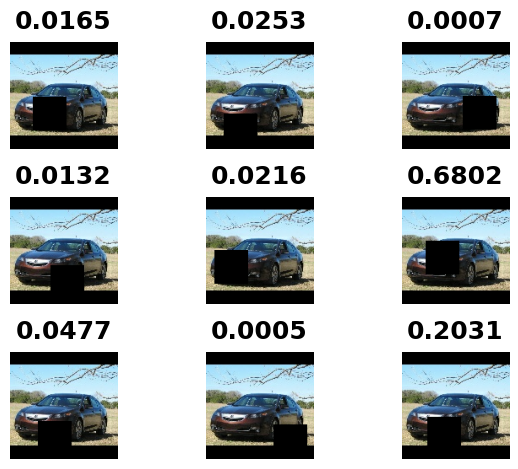

In [66]:
total_mask = np.zeros(img.shape)
rect_size = 40
for i in range(100):
    x,y = (np.random.random(2)*(128-rect_size)).round(0).astype(int)
    img_damaged = img.copy()
    img_damaged[y:y+rect_size,x:x+rect_size,:] = 0
    pred = model.predict(img_damaged[np.newaxis,:,:,:])
    if i<9:
      plt.subplot(3,3,i+1)
      plt.imshow(img_damaged)
      plt.axis('off')
      plt.title(f'{pred[0][0]:.4f}')
    mask = np.zeros(img.shape)
    mask[y:y+rect_size,x:x+rect_size,:] = pred[0][0]
    total_mask += mask
    # break
plt.show()

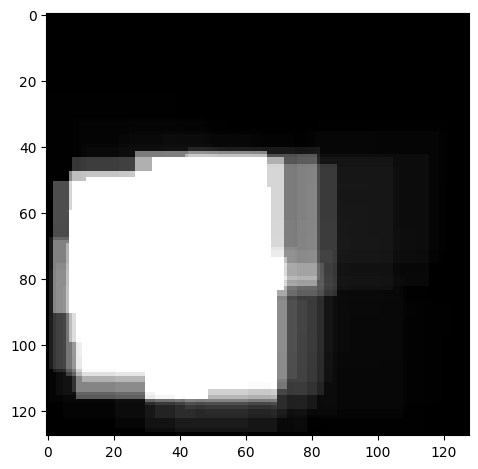

In [67]:
plt.imshow(total_mask)

In [68]:
total_mask.min(),total_mask.max()

(0.0, 7.700904320925474)

In [69]:
from keras.utils import load_img
# load the image with the required shape
img = load_img('/content/valid/Car/05138.jpeg', target_size=(128, 128))
from keras.utils import img_to_array
from tensorflow import expand_dims
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
img = img / 255

In [70]:
img.numpy().max(),img.numpy().min()

(1.0, 0.0)

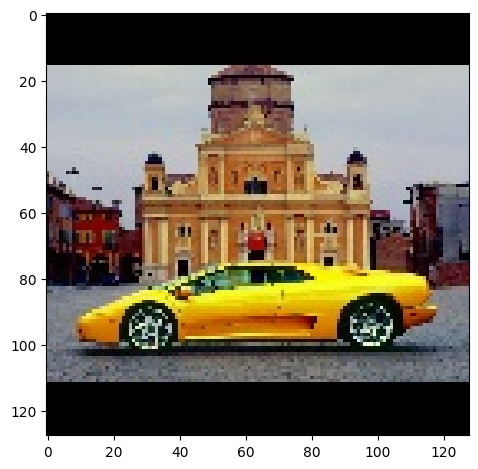

In [71]:
img_plot = img[0,:,:,:].numpy()
plt.imshow(img_plot)

In [72]:
model.predict(img)

1/1 [==============================] - 0s 30ms/step


array([[7.756547e-05]], dtype=float32)

In [73]:
img_numpy = img.numpy()
img_numpy[:,80:100,10:30,:] = 0

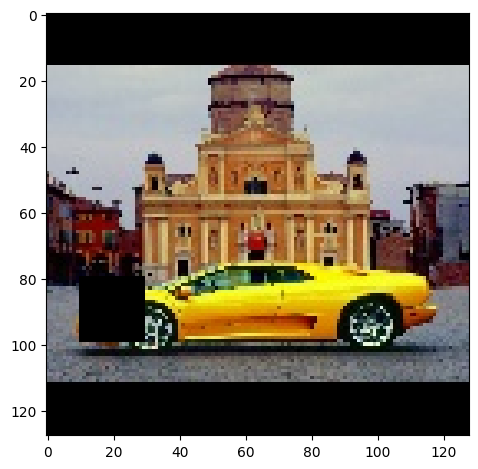

In [74]:
plt.imshow(img_numpy[0,:,:,:])

In [75]:
model.predict(img_numpy)

1/1 [==============================] - 0s 31ms/step


array([[2.9186185e-05]], dtype=float32)

1/1 [==============================] - 0s 29ms/step


array([[0.0543092]], dtype=float32)

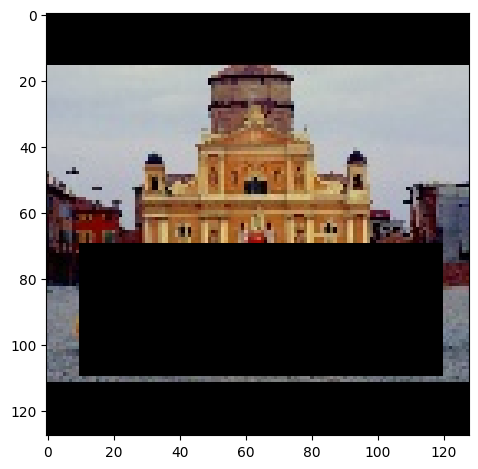

In [76]:
from keras.utils import load_img
# load the image with the required shape
img = load_img('/content/valid/Car/05138.jpeg', target_size=(128, 128))
from keras.utils import img_to_array
from tensorflow import expand_dims
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
img = img / 255

img_numpy = img.numpy()
img_numpy[:,70:110,10:120,:] = 0

plt.imshow(img_numpy[0,:,:,:])

model.predict(img_numpy)

1/1 [==============================] - 0s 27ms/step


array([[0.07253729]], dtype=float32)

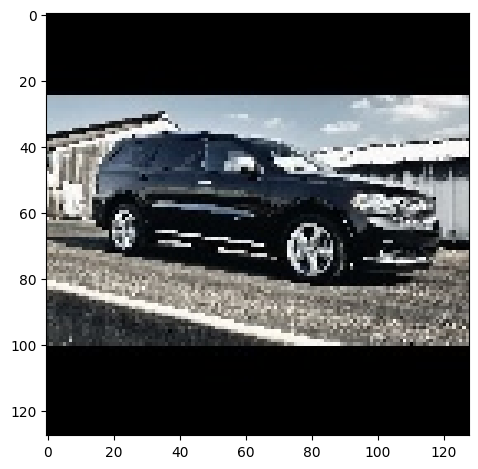

In [77]:
from keras.utils import load_img
# load the image with the required shape
img = load_img('/content/valid/Truck/05157.jpeg', target_size=(128, 128))
from keras.utils import img_to_array
from tensorflow import expand_dims
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
img = img / 255

img_numpy = img.numpy()
# img_numpy[:,70:110,10:120,:] = 0

plt.imshow(img_numpy[0,:,:,:])

model.predict(img_numpy)

In [79]:
img_numpy.shape

(1, 128, 128, 3)

1/1 [==============================] - 0s 32ms/step


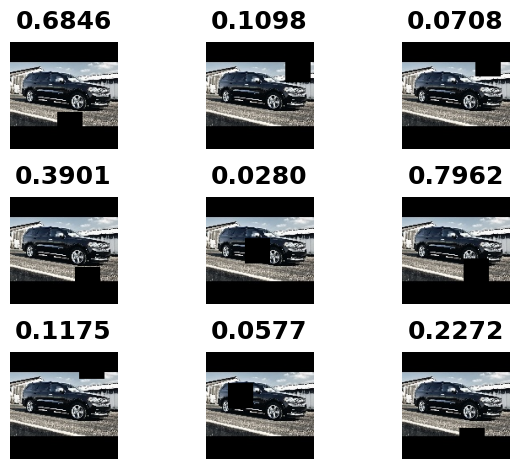

In [84]:
total_mask = np.zeros(img_numpy[0].shape)
rect_size = 30
for i in range(100):
    x,y = (np.random.random(2)*(128-rect_size)).round(0).astype(int)
    img_damaged = img_numpy[0].copy()
    img_damaged[y:y+rect_size,x:x+rect_size,:] = 0
    pred = model.predict(img_damaged[np.newaxis,:,:,:])
    if i<9:
      plt.subplot(3,3,i+1)
      plt.imshow(img_damaged)
      plt.axis('off')
      plt.title(f'{pred[0][0]:.4f}')
    mask = np.zeros(img_numpy[0].shape)
    mask[y:y+rect_size,x:x+rect_size,:] = pred[0][0]
    total_mask += mask
    # break
plt.show()

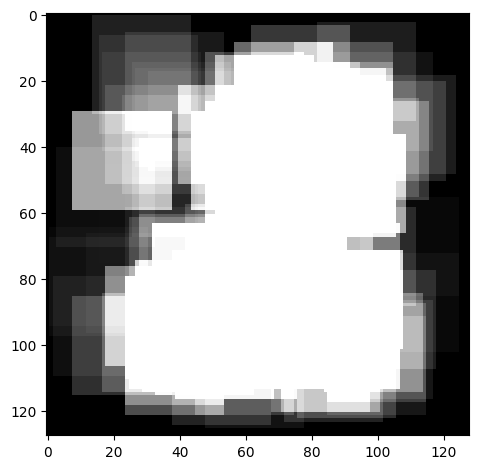

In [85]:
plt.imshow(total_mask)